In [1]:
import numpy as np

import math

%matplotlib inline
import matplotlib.colors
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.rcParams["figure.figsize"] = (5, 5)
from matplotlib.mlab import griddata

In [2]:

data_dir = '../data'
figure_dir = '../figures/morphing'

thetas = np.load(data_dir + '/thetas/thetas_parameterized.npy')

xi = np.linspace(-1.05, 1.05, 100)
yi = np.linspace(-1.05, 1.05, 100)
xx, yy = np.meshgrid(xi, yi)
thetas_eval = np.asarray(list(zip(xx.flatten(), yy.flatten())))


# Morphing weights

In [3]:
# Morphing
n_samples = 15

def calculate_wtilde(t, component_sample):
    wtilde_components = np.asarray([
        1. + 0. * t[:, 0],
        t[:, 1],
        t[:, 1] * t[:, 1],
        t[:, 1] * t[:, 1] * t[:, 1],
        t[:, 1] * t[:, 1] * t[:, 1] * t[:, 1],
        t[:, 0],
        t[:, 0] * t[:, 1],
        t[:, 0] * t[:, 1] * t[:, 1],
        t[:, 0] * t[:, 1] * t[:, 1] * t[:, 1],
        t[:, 0] * t[:, 0],
        t[:, 0] * t[:, 0] * t[:, 1],
        t[:, 0] * t[:, 0] * t[:, 1] * t[:, 1],
        t[:, 0] * t[:, 0] * t[:, 0],
        t[:, 0] * t[:, 0] * t[:, 0] * t[:, 1],
        t[:, 0] * t[:, 0] * t[:, 0] * t[:, 0]
    ]).T
    return wtilde_components.dot(component_sample)


def calculate_wi(t, component_sample, sigma_sample, sigma_component):
    wtildes = calculate_wtilde(t, component_sample)
    sigma_wtildes = sigma_sample * wtildes # (?, 15)
    
    denom = np.ones_like(sigma_wtildes.T) # (?, 15)
    denom[:,:] /= np.sum(sigma_wtildes, axis=1)
    denom = denom.T
    
    return (sigma_wtildes * denom).T

# Suboptimal morphing setup

In [4]:
thetas_morphing = np.array([
    [0.,0.],
    [0.,0.25],
    [0.,0.5],
    [0.,0.75],
    [0.,1.],
    [0.25,0.],
    [0.25,0.25],
    [0.25,0.5],
    [0.25,0.75],
    [0.5,0.],
    [0.5,0.25],
    [0.5,0.5],
    [0.75,0.],
    [0.75,0.25],
    [1.,0.]
])

sigma_component = np.load(data_dir + '/morphing/component_xsec.npy')[1:] # Ignore background component
component_sample = np.load(data_dir + '/morphing/component_sample.npy')[1:] # Ignore background component
sigma_sample = np.linalg.inv(component_sample).dot(sigma_component)

wi_original = calculate_wi(thetas_eval, component_sample, sigma_sample, sigma_component)

wi_original = wi_original.reshape(15,100,100)

wi_original_sum = np.sum(wi_original, axis=0)
print(np.min(wi_original_sum), np.max(wi_original_sum))
print(np.var(wi_original))

wi_original = np.clip(wi_original,-1000.,1000.)

0.9999999999995879 1.0000000000003126
12901.216665066362


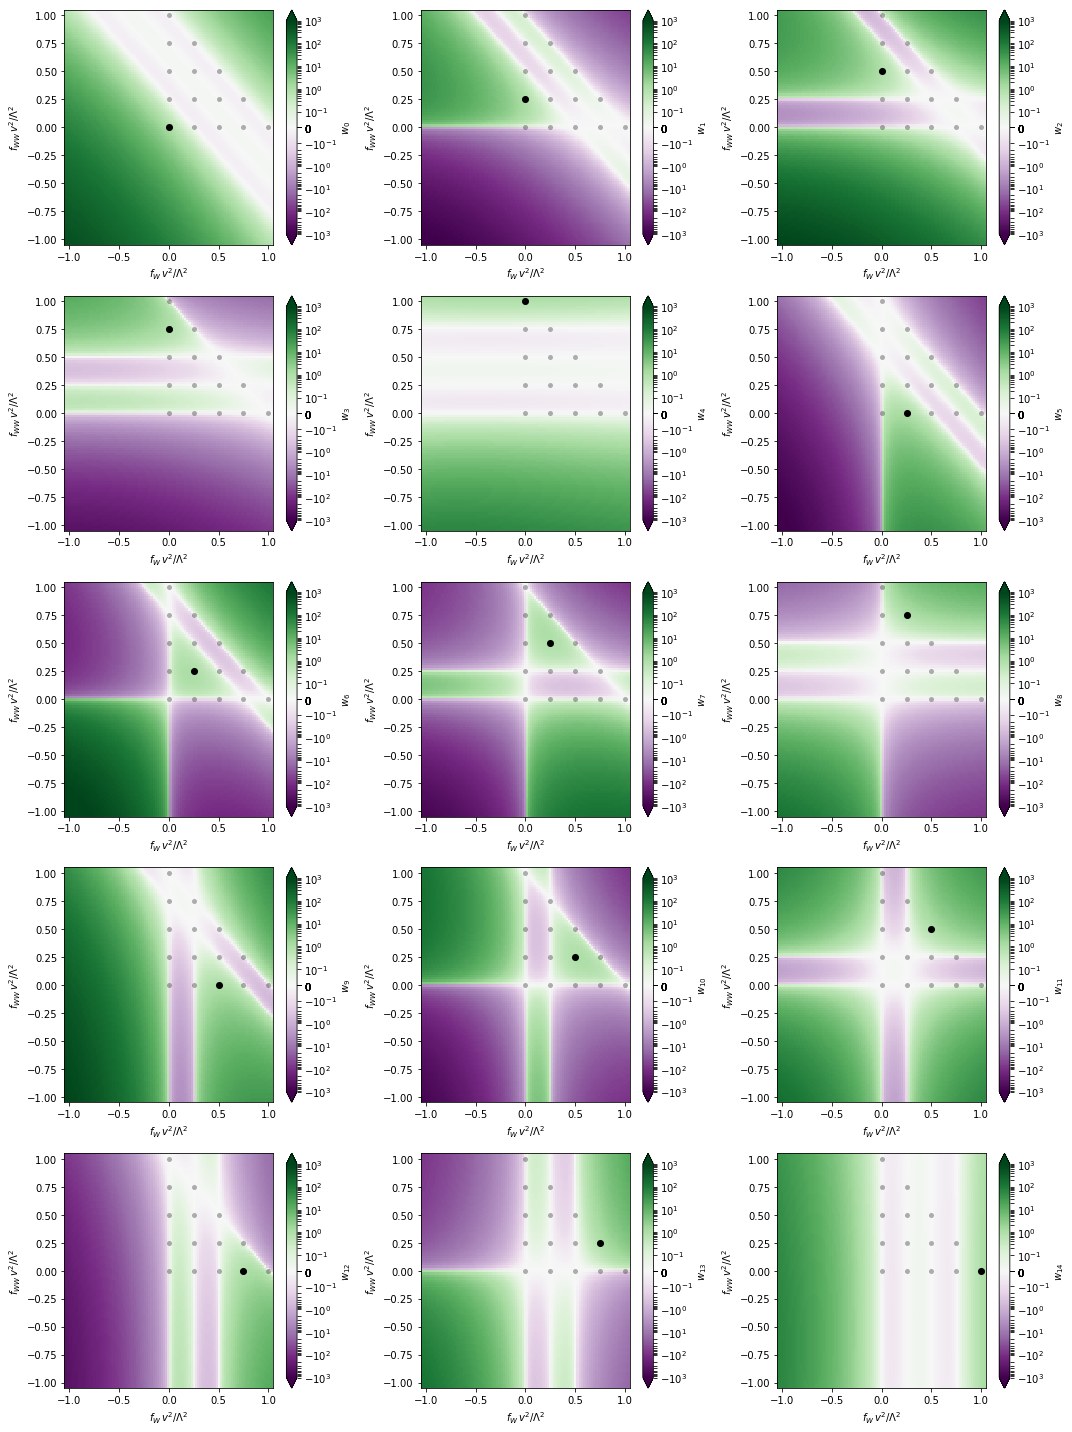

In [5]:
fig = plt.figure(figsize=(15,20))

for i in range(15):
    ax = plt.subplot(5, 3, i+1)
    
    pcm = ax.pcolormesh(xi, yi, wi_original[i],
                       norm=matplotlib.colors.SymLogNorm(linthresh=0.1, linscale=1.,
                                              vmin=-1000.0, vmax=1000.0),
                       cmap='PRGn')
    cbar = fig.colorbar(pcm, ax=ax, extend='both')

    plt.scatter(thetas_morphing[:, 0], thetas_morphing[:, 1],
                marker='o', c='black', s=25, lw=0, zorder=9, alpha=0.3)
    plt.scatter([thetas_morphing[i, 0]], [thetas_morphing[i, 1]],
                marker='o', c='black', s=50, lw=0, zorder=9, alpha=1.)

    plt.xlim(-1.05, 1.05)
    plt.ylim(-1.05, 1.05)
    plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
    plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
    cbar.set_label(r'$w_{'+ str(i) + r'}$')

plt.tight_layout()
plt.savefig(figure_dir + "/morphing_original.pdf")

# Better morphing setup (which we actually use)

(-1.1, 1.1)

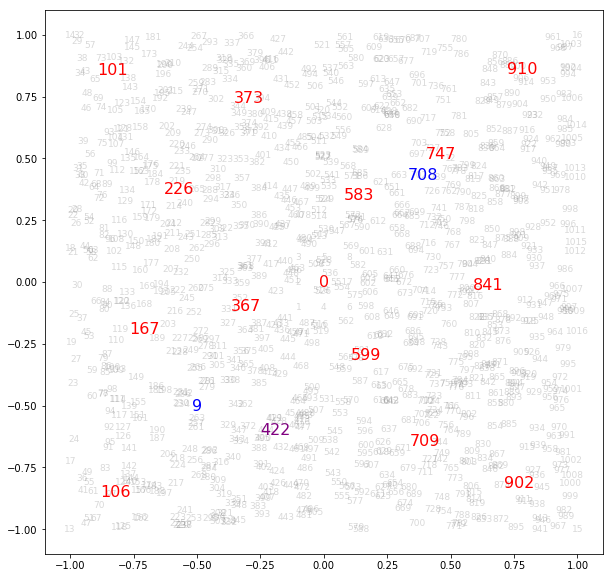

In [6]:
choice = [0, 101, 106, 902, 910,
              226, 373, 583, 747, 841,
              599, 709, 422, 367, 167]

benchmarks = [708, 9, 422]

plt.figure(figsize=(10,10))

for i, theta in enumerate(thetas):
    plt.text(theta[0],theta[1],str(i),
             fontsize = 16 if i in choice or i in benchmarks else 9,
             alpha = 1. if i in choice or i in benchmarks else 0.3,
             color = 'purple' if i in choice and i in benchmarks else 'red' if i in choice else 'blue' if i in benchmarks else 'grey',
             horizontalalignment = 'center',
             verticalalignment = 'center')
    
plt.xlim(-1.1,1.1)
plt.ylim(-1.1,1.1)

In [8]:
thetas_used_morphing = thetas[choice]

sample_component = np.load(data_dir + '/morphing/components_fakebasis2.npy')[:,1:] # Ignore background component
component_sample = np.linalg.inv(sample_component)
sigma_sample = np.load(data_dir + '/morphing/fakebasis2_xsecs.npy')
sigma_component = component_sample.dot(sigma_sample)

wi_used = calculate_wi(thetas_eval, component_sample, sigma_sample, sigma_component)
wi_used = wi_used.reshape(15,100,100)

wi_used_sum = np.sum(wi_used, axis=0)
print(np.min(wi_used_sum), np.max(wi_used_sum))
print(np.var(wi_used))

wi_used = np.clip(wi_used,-1000.,1000.)

0.9999999999999414 1.000000000000051
121.3292922608206


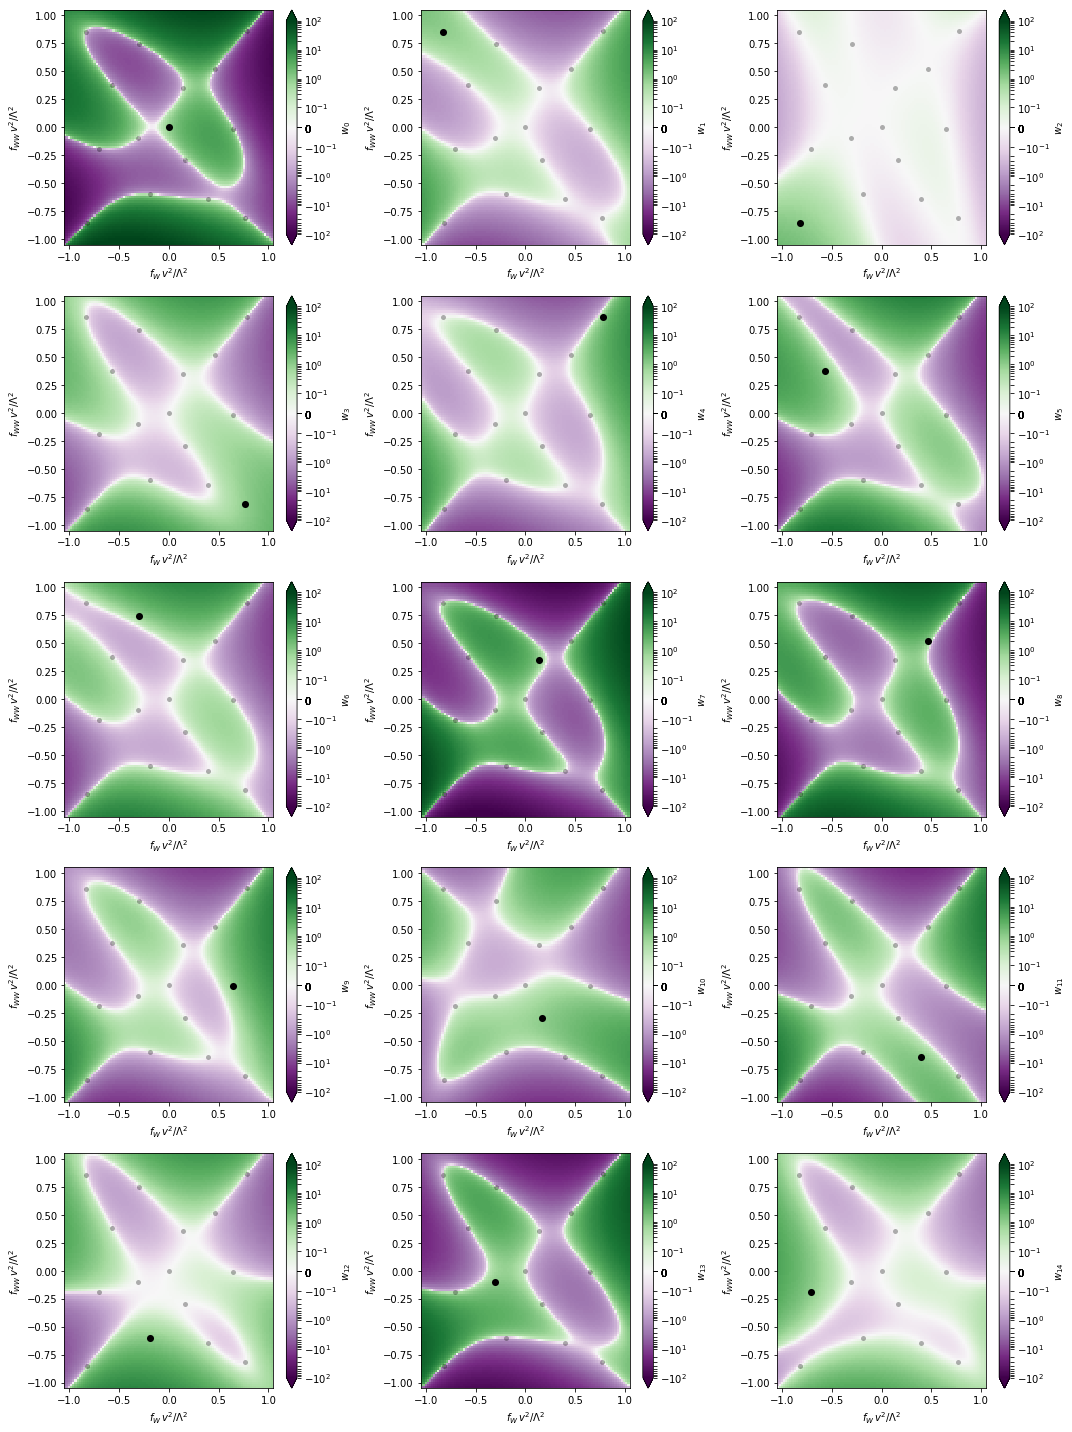

In [9]:
fig = plt.figure(figsize=(15,20))

for i in range(15):
    ax = plt.subplot(5, 3, i+1)
    
    pcm = ax.pcolormesh(xi, yi, wi_used[i],
                       norm=matplotlib.colors.SymLogNorm(linthresh=0.1, linscale=1.,
                                              vmin=-100.0, vmax=100.0),
                       cmap='PRGn')
    cbar = fig.colorbar(pcm, ax=ax, extend='both')

    plt.scatter(thetas_used_morphing[:, 0], thetas_used_morphing[:, 1],
                marker='o', c='black', s=25, lw=0, zorder=9, alpha=0.3)
    plt.scatter([thetas_used_morphing[i, 0]], [thetas_used_morphing[i, 1]],
                marker='o', c='black', s=50, lw=0, zorder=9, alpha=1.)

    plt.xlim(-1.05, 1.05)
    plt.ylim(-1.05, 1.05)
    plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
    plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
    cbar.set_label(r'$w_{'+ str(i) + r'}$')

plt.tight_layout()
plt.savefig(figure_dir + "/morphing_big.pdf")

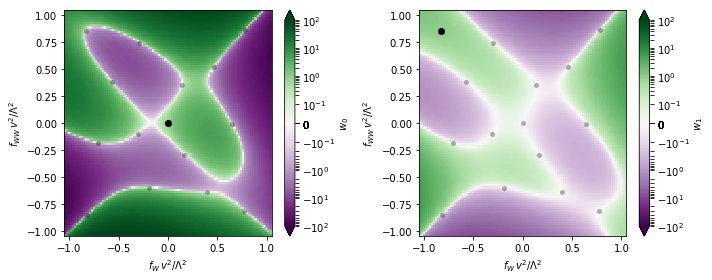

In [10]:
fig = plt.figure(figsize=(10.,4.))

for i in range(2):
    ax = plt.subplot(1, 2, i+1)
    
    pcm = ax.pcolormesh(xi, yi, wi_used[i],
                       norm=matplotlib.colors.SymLogNorm(linthresh=0.1, linscale=1.,
                                              vmin=-100.0, vmax=100.0),
                       cmap='PRGn')
    cbar = fig.colorbar(pcm, ax=ax, extend='both')

    plt.scatter(thetas_used_morphing[:, 0], thetas_used_morphing[:, 1],
                marker='o', c='black', s=25, lw=0, zorder=9, alpha=0.3)
    plt.scatter([thetas_used_morphing[i, 0]], [thetas_used_morphing[i, 1]],
                marker='o', c='black', s=50, lw=0, zorder=9, alpha=1.)

    plt.xlim(-1.05, 1.05)
    plt.ylim(-1.05, 1.05)
    plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
    plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
    cbar.set_label(r'$w_{'+ str(i) + r'}$')

plt.tight_layout()
plt.savefig(figure_dir + "/morphing.pdf")

# Errors from morphing

In [27]:
delta_ri = 1.

delta_wi_used = np.zeros_like(wi_used[0])

for wi in wi_used:
    delta_wi_used += wi**2 * delta_ri**2
    
delta_wi_used = np.sqrt(delta_wi_used)

print(np.min(delta_wi_used))

0.678271341906766


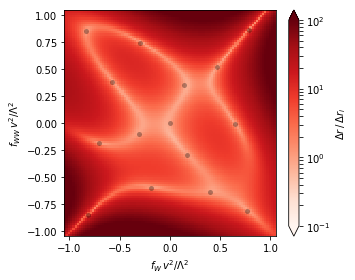

In [26]:
fig = plt.figure(figsize=(5.,4.))
ax = plt.gca()
    
pcm = ax.pcolormesh(xi, yi, delta_wi_used,
                   norm=matplotlib.colors.LogNorm(vmin=0.1, vmax=100.0),
                   cmap='Reds')
cbar = fig.colorbar(pcm, ax=ax, extend='both')

plt.scatter(thetas_used_morphing[:, 0], thetas_used_morphing[:, 1],
            marker='o', c='black', s=25, lw=0, zorder=9, alpha=0.3)

plt.xlim(-1.05, 1.05)
plt.ylim(-1.05, 1.05)
plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
cbar.set_label(r'$\Delta r \, / \, \Delta r_i$')

plt.tight_layout()
plt.savefig(figure_dir + "/morphing_uncertainties.pdf")

# Weights from morphing-aware network 

In [51]:
ri_nottrained = np.load('../results/parameterized/morphing_wi_nottrained_carl_aware_basis.npy')
wi_nottrained = np.load('../results/parameterized/morphing_ri_nottrained_carl_aware_basis.npy')[0]
r_nottrained = np.load('../results/parameterized/r_nottrained_carl_aware_basis.npy')
ri_trained = np.load('../results/parameterized/morphing_wi_trained_carl_aware_basis.npy')
wi_trained = np.load('../results/parameterized/morphing_ri_trained_carl_aware_basis.npy')[0]
r_trained = np.load('../results/parameterized/r_trained_carl_aware_basis.npy')

theta_trained = 422
theta_nottrained = 9

In [46]:
wi_trained_true = calculate_wi(np.asarray([thetas[theta_trained]]),
                               component_sample, sigma_sample, sigma_component).reshape((-1,))
wi_nottrained_true = calculate_wi(np.asarray([thetas[theta_nottrained]]),
                               component_sample, sigma_sample, sigma_component).reshape((-1,))

In [50]:
print(wi_trained)
print(wi_trained_true)
print(wi_trained - wi_trained_true)

print('')

print(wi_nottrained)
print(wi_nottrained_true)
print(wi_nottrained-wi_nottrained_true)

[-1.5685592e-06  1.0774480e-07 -1.7456896e-09 -1.4361480e-07
  9.9741698e-08 -2.6397331e-07 -1.4546788e-07 -7.9567707e-07
 -5.3040907e-07  1.6954810e-07  1.5721119e-07  4.4933245e-07
  1.0000017e+00  9.0055096e-07 -4.9222979e-08]
[ 9.55897104e-16 -4.15251401e-15  7.47922420e-17 -1.16240070e-15
 -4.82470911e-16 -7.45246754e-16 -4.22310107e-16 -2.50232508e-15
 -7.19954388e-15  9.41304907e-15 -3.27380864e-16 -1.38233423e-15
  1.00000000e+00  2.74509145e-15 -1.33322528e-15]
[-1.56855924e-06  1.07744807e-07 -1.74568967e-09 -1.43614797e-07
  9.97416981e-08 -2.63973305e-07 -1.45467879e-07 -7.95677065e-07
 -5.30409061e-07  1.69548092e-07  1.57211190e-07  4.49332448e-07
  1.66893005e-06  9.00550956e-07 -4.92229781e-08]

[-6.8415465   0.32128537  0.144119   -0.26008308  0.17167953 -0.964056
 -0.5357892   4.5098977  -1.6826981   0.46183938  1.0012074   0.44210222
 -0.02847112  4.41144    -0.15092601]
[-6.8415364   0.32128504  0.14411881 -0.26008274  0.17167923 -0.96405491
 -0.53578846  4.50989207

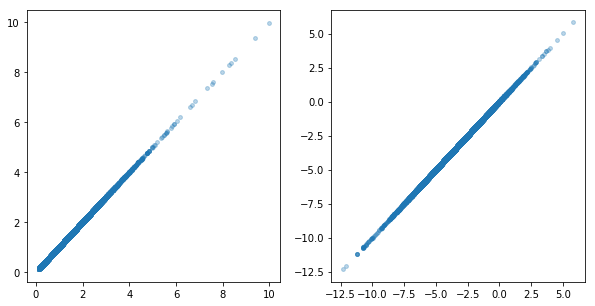

In [61]:
plt.figure(figsize=(10.,5.))

plt.subplot(1,2,1)
plt.scatter(ri_trained[:,12], r_trained, s=15., alpha=0.3)

plt.subplot(1,2,2)
plt.scatter(ri_nottrained.dot(wi_nottrained), r_nottrained, s=15., alpha=0.3)

plt.show()